In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps

Считываем исходный экселевский файл со средними уровнями цен, частотами заказов и т.д.

In [2]:
source = pd.read_excel('quadro_like.xlsx', header=1).iloc[:, :8]
source.head()

,компания,отрасль,продукция,регион,город,цены средний уровень,частота заказов,менеджер
0,Ёлки-палки,артефакторика,палочки,Тмутаракань,Тумантархан,4,100,Синдбад
1,Змей Горыныч: Гриль и мясо,яства,дичь,Лукоморье,Лукоморск,2,180,Садко
2,Бабки Ёжки,зелья,порошки,Лукоморье,Пушград,4,80,Синдбад
3,Олливандер,артефакторика,палочки,Тмутаракань,Тамань,4,45,Садко
4,Зельевар,зелья,элексиры,Лукоморье,Котовск,6,18,Синдбад


In [4]:
source.columns = [
    'company', 
    'industry', 
    'product', 
    'region', 
    'town', 
    'price_level', 
    'order_frequency', 
    'manager', 
]

In [8]:
source.dtypes

company            object
industry           object
product            object
region             object
town               object
price_level         int64
order_frequency     int64
manager            object
dtype: object

Создадим и сохраним таблицы-справочники, которые будем использовать в BI-системах

In [390]:
companies = source[[
    'company', 
    'product', 
    'town', 
    'manager', 
]]
companies.head()

,company,product,town,manager
0,Ёлки-палки,палочки,Тумантархан,Синдбад
1,Змей Горыныч: Гриль и мясо,дичь,Лукоморск,Садко
2,Бабки Ёжки,порошки,Пушград,Синдбад
3,Олливандер,палочки,Тамань,Садко
4,Зельевар,элексиры,Котовск,Синдбад


In [398]:
companies.columns = ['Артель', 'Товар', 'Град', 'Купец']

In [408]:
companies.to_csv('companies.csv', index=False, encoding='utf-8')

In [393]:
industries = source[[
    'product',  
    'industry', 
]].drop_duplicates().sort_values(['industry', 'product'])
industries

,product,industry
13,амуниция,артефакторика
17,кольца,артефакторика
0,палочки,артефакторика
24,всяко,всячина
2,порошки,зелья
16,травы,зелья
4,элексиры,зелья
5,веган,яства
1,дичь,яства
6,киселя,яства


In [409]:
industries.columns = ['Товар', 'Промысел']

In [410]:
industries.to_csv('industries.csv', index=False, encoding='utf-8')

In [394]:
regions = source[[
    'town',  
    'region', 
]].drop_duplicates().sort_values(['region', 'town'])
regions

,town,region
20,Дубовск,Лукоморье
4,Котовск,Лукоморье
1,Лукоморск,Лукоморье
2,Пушград,Лукоморье
22,Анвард,Нарния
7,Кэр-Параваль,Нарния
3,Тамань,Тмутаракань
0,Тумантархан,Тмутаракань
10,Красноярск-26,Тридесятое
17,Томск-7,Тридесятое


In [411]:
regions.columns = ['Град', 'Царство']

In [412]:
regions.to_csv('regions.csv', index=False, encoding='utf-8')

Нагенерируем реестр отгрузочных документов за 2048 год

In [5]:
price_levels = source[['company', 'price_level']].set_index('company')
price_levels.head()

,price_level
company,
Ёлки-палки,4
Змей Горыныч: Гриль и мясо,2
Бабки Ёжки,4
Олливандер,4
Зельевар,6


In [29]:
sales = pd.DataFrame({
    'sales_date': [], 
    'company': [], 
    'amount':[]
})
sales

,sales_date,company,amount


In [30]:
for day in pd.date_range('2048-01-01', '2048-12-31'):
    if day.weekday() not in (5, 6,):  # сб и вс - выходные
        for _ in range(sps.binom(n=10, p=0.5).rvs()):  # кол-во отгрузок в день из биномиального распределения
            # выбираем случайную компанию из списка, учитывая частоты из таблицы
            random_company = np.random.choice(source.company, p=source.order_frequency / source.order_frequency.sum()), 
            random_company = random_company[0]
            # добавляем очередную строку данных
            sales = sales.append(
                {
                    'sales_date': day, 
                    'company': random_company, 
                    'amount': (200 * price_levels.loc[random_company].price_level * (20 + 6 * sps.norm().rvs())).round(2)
                }
                , ignore_index=True)
            

In [31]:
sales.head()

,sales_date,company,amount
0,2048-01-01,Каша из топора,10208.64
1,2048-01-01,Бабки Ёжки,21961.11
2,2048-01-01,Хоббитонские угощения,6905.58
3,2048-01-01,Дырявый котёл,4571.70
4,2048-01-01,Ёлки-палки,15124.69


In [32]:
sales.columns = ['Дата', 'Артель', 'Плата']

Посмотрим выглядит ли правдоподобно наш набор данных

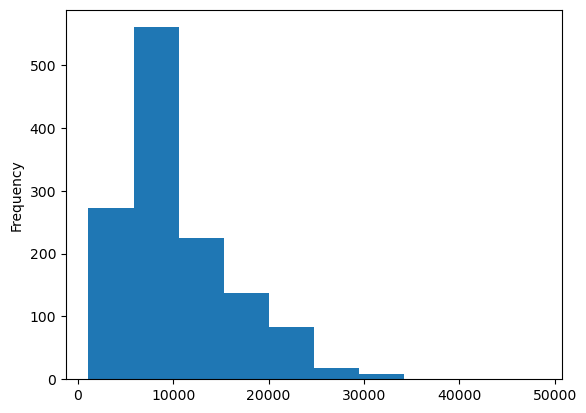

In [37]:
sales.Плата.plot.hist();

In [36]:
sales.Артель.value_counts().head()

Змей Горыныч: Гриль и мясо    226
Ёлки-палки                    142
Бабки Ёжки                    108
Каша из топора                 72
Олливандер                     54
Name: Артель, dtype: int64

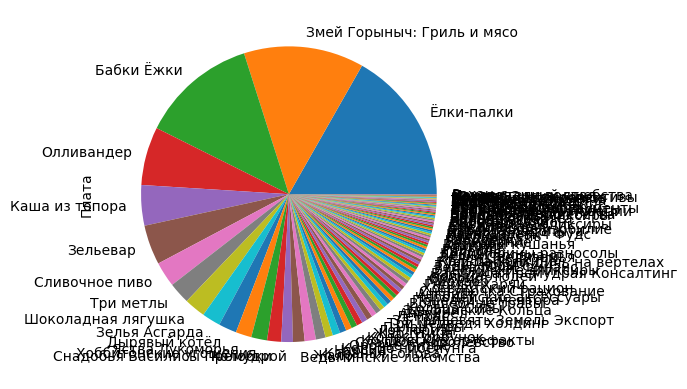

In [35]:
(sales.groupby('Артель').Плата.sum().sort_values(ascending=False) / sales.Плата.sum()).plot.pie();

In [34]:
sales.groupby('Артель').Плата.mean().round(2).sort_values(ascending=False).head(10)

Артель
Мирувор                   48395.08
Ангуирел                  32960.04
Кольца Силы               29938.22
Колдовские артефакты      29038.31
Зельевар                  22657.25
Кольца Людей              21725.68
Жало                      18484.91
Кольцо нибелунга          18455.56
Чародейские аксессуары    18065.33
Ангрист                   17783.85
Name: Плата, dtype: float64

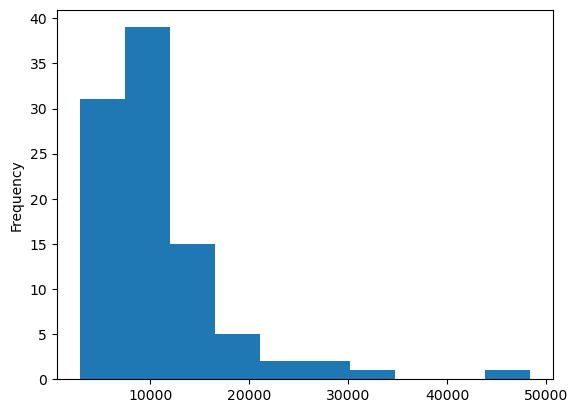

In [33]:
sales.groupby('Артель').Плата.mean().plot.hist();

In [38]:
sales.to_csv('sales.csv', index=False, encoding='utf-8')

In [ ]:
2042

In [9]:
source.dtypes

company            object
industry           object
product            object
region             object
town               object
price_level         int64
order_frequency     int64
manager            object
dtype: object